Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, so the decorrelated diffim now lies in:
```
decamDirTest/deepDiff/v289820/diffexp-11.fits
```

Without the correction, at 5.5 sigma, 58,98 positive,negative sources were detected (143 merged). 
At 5.0 sigma, it is 89,328 (395 merged).

With the correction (at 5.5-sigma) it is only 35,15 (41 merged).
At 5.0 sigma on the decorrelated image we get 40,18 detections (47 merged).

In [12]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import scipy.stats

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit
import lsst.ip.diffim.imageDecorrelation as id

reload(dit)
reload(id);

In [2]:
im1 = afwImage.ExposureF('diffexp-11.fits')
im2 = afwImage.ExposureF('decamDirTest/deepDiff/v289820/diffexp-11.fits')

# Also load the original science and template images
sciImg = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
templImg = afwImage.ExposureF('calexpDir_b1631/0288976/calexp/calexp-0288976_11.fits')

In [3]:
print 'Stats of variance planes:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
print dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im1.getMaskedImage().getVariance(),
                                maskIm=im1.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance(),
                                maskIm=im2.getMaskedImage().getMask())

print '\nStats of image pixels:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage())
print dit.computeClippedAfwStats(templImg.getMaskedImage())
print dit.computeClippedAfwStats(im1.getMaskedImage())
print dit.computeClippedAfwStats(im2.getMaskedImage())

Stats of variance planes:
(62.77782901700841, 2.5060648726354002, 6.280361145857084)
(59.99452575747201, 2.4514634731193685, 6.009673160038477)
(66.87903634374102, 2.5179893368341237, 6.340270300410351)
(125.6909511869846, 4.695624493360114, 22.04888938264343)

Stats of image pixels:
(0.0005585483212044934, 8.311411313575924, 69.07955802343785)
(0.0004579826852987869, 8.164932806235559, 66.66612773034169)
(-0.4661162311167405, 8.61241098523501, 74.17362297859668)
(-0.4657583555047659, 11.70937038788749, 137.10935488073645)


UNCORRECTED: (-0.4661162311167405, 8.61241098523501, 74.17362297859668)
CORRECTED:   (-0.4657583555047659, 11.70937038788749, 137.10935488073645)
8090901 7945180


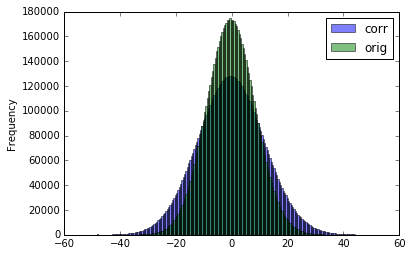

In [4]:
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1.getMaskedImage())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2.getMaskedImage())
#print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1.getMaskedImage().getImage().getArray())
im2a = getClippedPixels(im2.getMaskedImage().getImage().getArray())
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.349174543978
0.04389047764


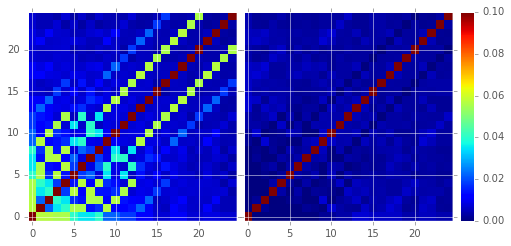

In [5]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im1a)
im1a[(im1a < low)|(im1a > upp)] = 0.
cov1 = dit.computePixelCovariance(im1a)

im2a = im2.getMaskedImage().getImage().getArray()
im2a[np.isnan(im2a)|np.isinf(im2a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im2a)
im2a[(im2a < low)|(im2a > upp)] = 0.
cov2 = dit.computePixelCovariance(im2a)

dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.15869873174
1.00014561851 1.0
(14, 14) (14, 15)


DescribeResult(nobs=841, minmax=(-0.0039626161898166784, 0.0064074308058247424), mean=1.7314923478935555e-07, variance=4.5920531907183518e-07, skewness=3.2404998474732456, kurtosis=36.04173896717515)

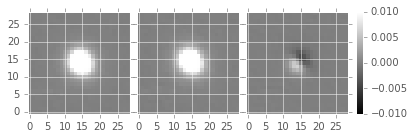

In [6]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance plane appears to be getting set too high in the corrected diffim...?
(130 vs. expected 123...?)

But I think this is too high because we are including the non-convolved pixels (around the edges) in the statistics.
Need to include the masks in the statistics.

SCIENCE: (62.77782901700841, 2.5060648726354002, 6.280361145857084)
TEMPLATE:   (59.99452575747201, 2.4514634731193685, 6.009673160038477)
UNCORRECTED: (66.87903634374102, 2.5179893368341237, 6.340270300410351)
CORRECTED:   (125.6909511869846, 4.695624493360114, 22.04888938264343)
EXPECTED:    122.772354774
7520808 7242570 8087169 8089345


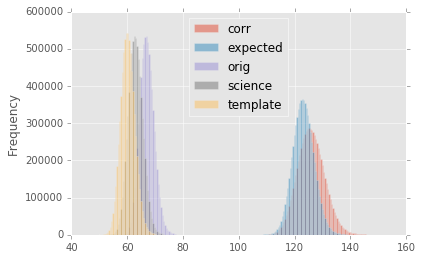

In [7]:
im1a = im1.getMaskedImage().getVariance()
im2a = im2.getMaskedImage().getVariance()
imsa = sciImg.getMaskedImage().getVariance()
imta = templImg.getMaskedImage().getVariance()

tmp = sciImg.getMaskedImage().clone()
tmp -= templImg.getMaskedImage()
tmp = tmp.getVariance()

print 'SCIENCE:', dit.computeClippedAfwStats(imsa, maskIm=sciImg.getMaskedImage().getMask())
print 'TEMPLATE:  ', dit.computeClippedAfwStats(imta, maskIm=templImg.getMaskedImage().getMask())
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1a, maskIm=im1.getMaskedImage().getMask())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2a, maskIm=im2.getMaskedImage().getMask())
expected = dit.computeClippedAfwStats(imsa, maskIm=sciImg.getMaskedImage().getMask())[0] + \
           dit.computeClippedAfwStats(imta, maskIm=templImg.getMaskedImage().getMask())[0]
print 'EXPECTED:   ', expected

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1a.getArray())
im2a = getClippedPixels(im2a.getArray())
imsa = getClippedPixels(imsa.getArray())
imta = getClippedPixels(imta.getArray())
tmp = getClippedPixels(tmp.getArray())
print len(im1a), len(im2a), len(imsa), len(imta)
im1a = im1a[:len(im2a)]
imsa = imsa[:len(im2a)]
imta = imta[:len(im2a)]
tmp = tmp[:len(im2a)]
expected = tmp

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a, 'science': imsa, 'template': imta, 'expected': expected})
df.plot.hist(alpha=0.5, bins=200)

See how the variance plane statistics are varying across the images...

Compute statistics across 100x100-pixel boxes on the image. 

70.0 0.496947467017
132.610424878 0.934006144129
64.12224528 0.45814728892
61.5340751045 0.453035093481


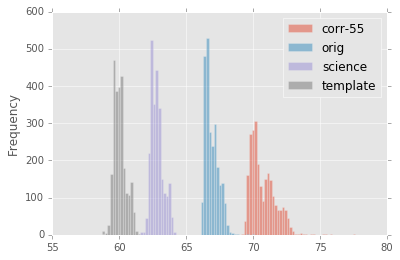

In [200]:
import lsst.afw.geom as afwGeom

def computeVarianceBoxStats(im, doPixelsInstead=False):
    im1a = im.getMaskedImage().getVariance()
    if doPixelsInstead:
        im1a = im.getMaskedImage().getImage()
    im1m = im.getMaskedImage().getMask()
    box = im1a.getBBox()
    sz = im1a.getArray().shape
    boxSize = afwGeom.ExtentI(100, 100)
    boxes = [afwGeom.Box2I(afwGeom.PointI(x, y), boxSize) for y in np.linspace(0, sz[0]-101, 50, dtype=int) \
             for x in np.linspace(0, sz[1]-101, 50, dtype=int)]
    subims = [[afwImage.ImageF(im1a, box, afwImage.PARENT), afwImage.MaskU(im1m, box, afwImage.PARENT)] for box in boxes]
    return [dit.computeClippedAfwStats(sub[0], maskIm=sub[1]) for sub in subims]

# Plot means in variance planes...
tmp = computeVarianceBoxStats(im1)
im1stats = np.array([t[0] for t in tmp]); im1stats[im1stats>70] = 70; print im1stats.max(), im1stats.std()
tmp = computeVarianceBoxStats(im2)
im2stats = np.array([t[0] for t in tmp]); im2stats[im2stats>135] = 125; print im2stats.max(), im2stats.std()
tmp = computeVarianceBoxStats(sciImg)
scistats = np.array([t[0] for t in tmp]); print scistats.max(), scistats.std()
tmp = computeVarianceBoxStats(templImg)
templstats = np.array([t[0] for t in tmp]); print templstats.max(), templstats.std()

df = pd.DataFrame({'corr-55': im2stats-55., 'orig': im1stats, 'science': scistats, 'template': templstats})
#df = pd.DataFrame({'orig': im1stats, 'science': scistats, 'template': templstats})
df.plot.hist(alpha=0.5, bins=100)

OK, then let's look at the matching kernel variation across the image.

Ran imageDecorrelation with this code added to dump the spatialKernel (it can be pickled!):

```
cPickle.dump(spatialKernel, gzip.GzipFile('spatialKernel.p.gz', 'wb'))
```

In [3]:
import cPickle
import gzip
im1a = im1.getMaskedImage().getVariance()
bbox = im1a.getBBox()
spatialKernel = cPickle.load(gzip.GzipFile('spatialKernel.p.gz', 'rb'))

def getSpatialKernelImage(spatialKernel, xcen, ycen):
    kimg = afwImage.ImageD(spatialKernel.getDimensions())
    spatialKernel.computeImage(kimg, True, xcen, ycen)
    return kimg.getArray()

kimages = [getSpatialKernelImage(spatialKernel, xc, yc) for
           xc in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for
           yc in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
print "HERE:", len(kimages)

HERE: 100


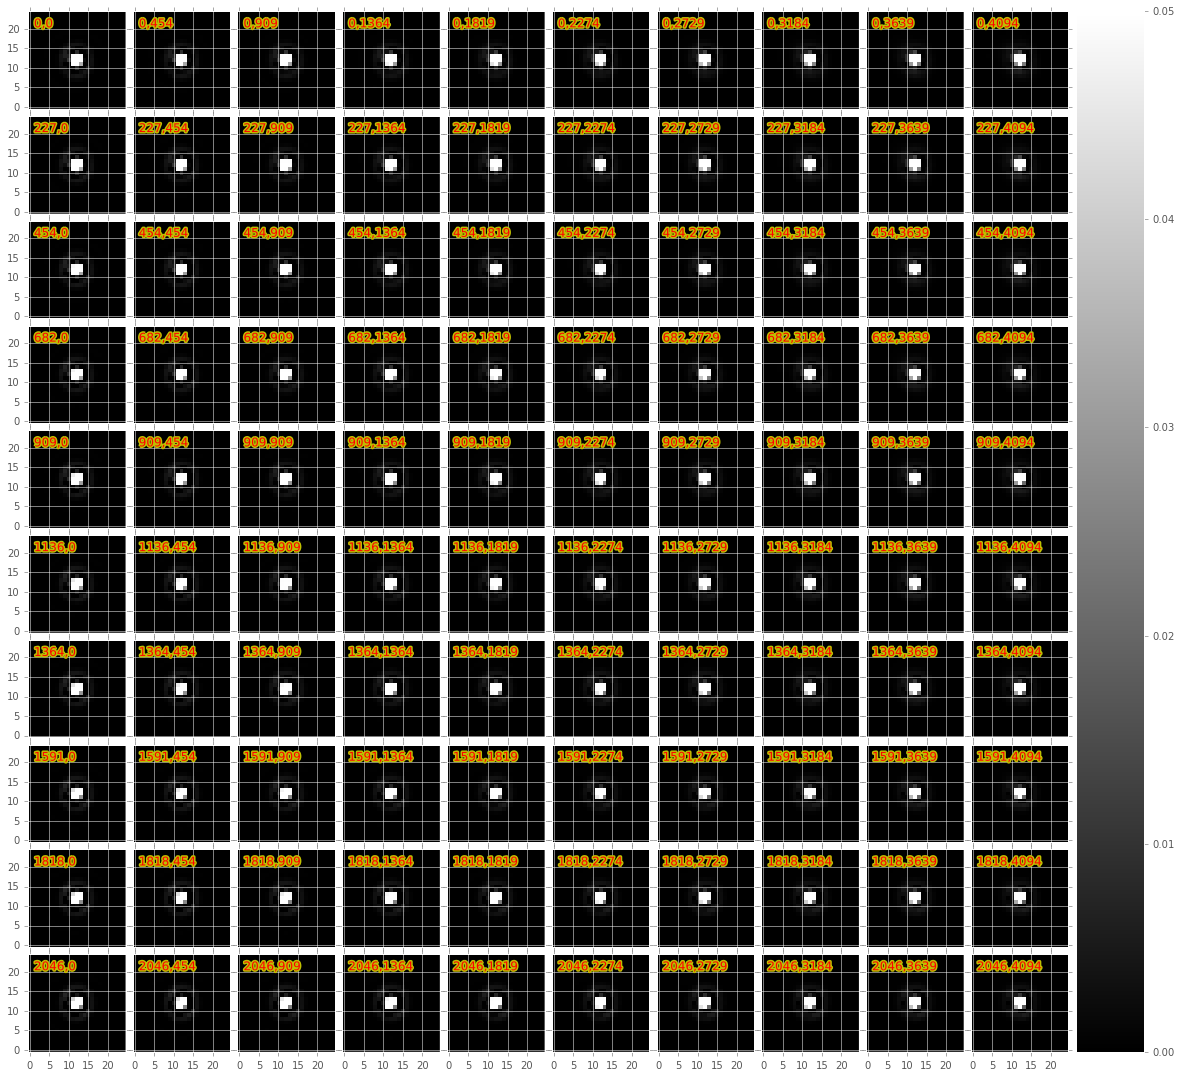

In [11]:
titles = ['%d,%d' % (x,y) for \
          x in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for \
          y in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
dit.plotImageGrid(kimages, imScale=2., clim=(0., 0.05), titles=titles)

Compute the decorrelation kernel for each of these matching kernels...

['/Users/dreiss/GIT_REPOS/TICKETS/DM-6580/ip_diffim/python/lsst/ip/diffim']


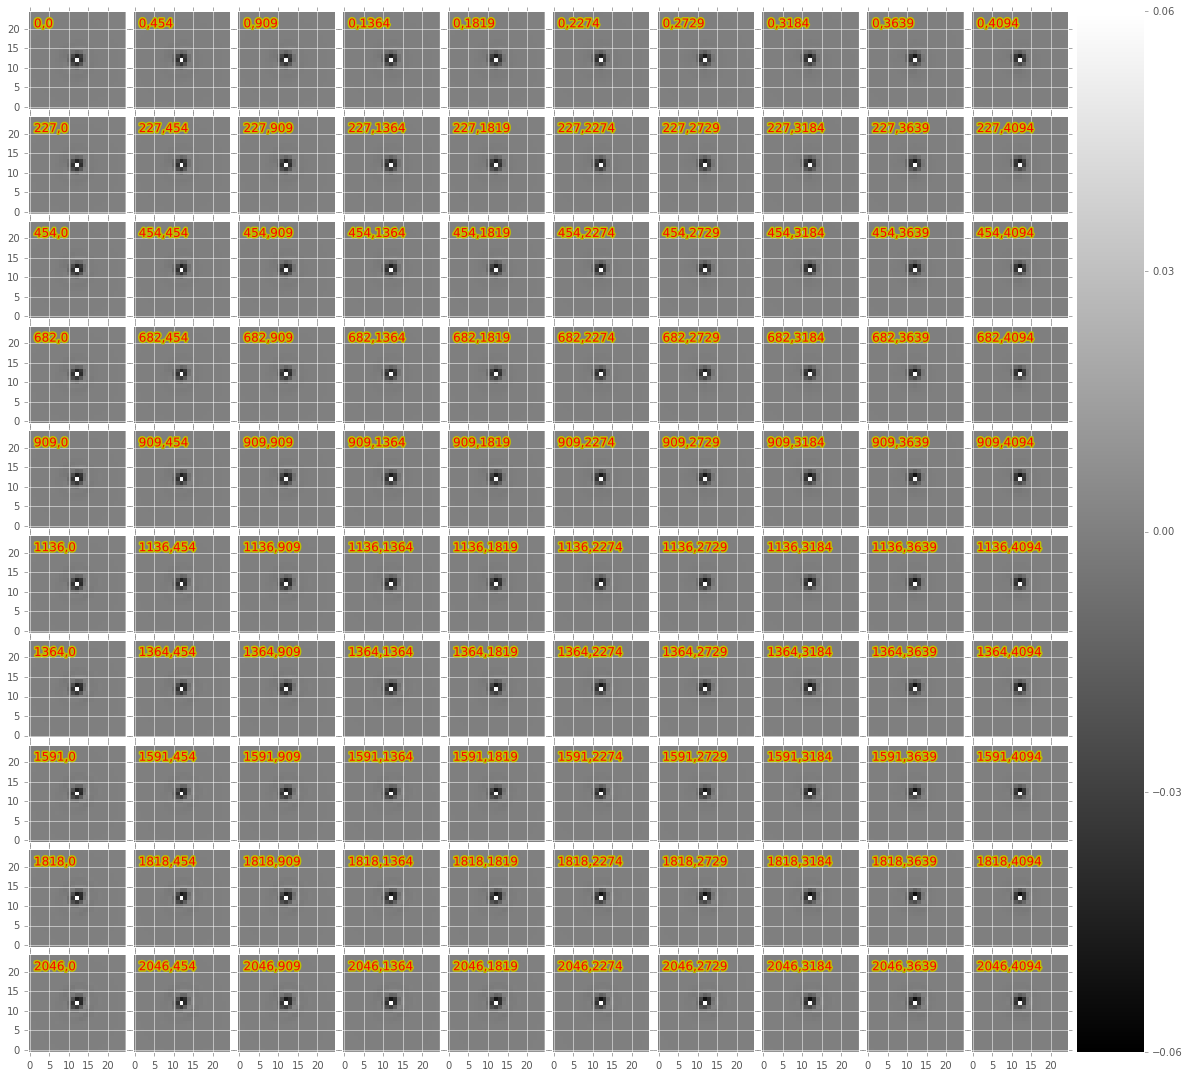

In [12]:
from lsst.ip.diffim import DecorrelateALKernelTask
import lsst.ip.diffim as ipDiffim
print ipDiffim.__path__

_, _, var1 = dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
_, _, var2 = dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())

kimages2 = [DecorrelateALKernelTask._fixOddKernel(kimg) for kimg in kimages]

corrKernels = [DecorrelateALKernelTask._computeDecorrelationKernel(kimg, var1=var1, var2=var2) \
               for kimg in kimages]
corrKernels = [DecorrelateALKernelTask._fixEvenKernel(kimg) for kimg in corrKernels]
#print [np.max(k) for k in corrKernels]

titles = ['%d,%d' % (x,y) for \
          x in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for \
          y in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
dit.plotImageGrid(corrKernels, imScale=2., clim=(-0.06, 0.06), titles=titles)

In [13]:
%timeit DecorrelateALKernelTask._computeDecorrelationKernel(kimages[0], var1=var1, var2=var2)

1000 loops, best of 3: 374 µs per loop


Find the matching kernels that are the most different, then compare them and their resulting decor. kernels...

0.0861250926096 990 [9, 90]


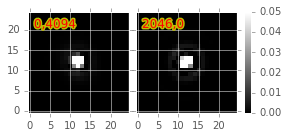

In [14]:
diffs = [np.sqrt(np.sum((k1 - k2)**2.)) for k1 in kimages for k2 in kimages]
coords = [[i, j] for i in range(len(kimages)) for j in range(len(kimages))]
print np.max(diffs), np.argmax(diffs), coords[np.argmax(diffs)]
coo = coords[np.argmax(diffs)]
dit.plotImageGrid([kimages[coo[0]], kimages[coo[1]]], imScale=2., clim=(0., 0.05), 
                  titles=[titles[coo[0]], titles[coo[1]]])

1.34368498459 1.33742425907
1.34368498459 1.33742425907


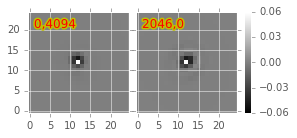

In [15]:
print corrKernels[coo[0]].max(), corrKernels[coo[1]].max()
dit.plotImageGrid([corrKernels[coo[0]], corrKernels[coo[1]]], imScale=2., clim=(-0.06, 0.06), 
                  titles=[titles[coo[0]], titles[coo[1]]])
print np.max([kc.max() for kc in corrKernels]), np.min([kc.max() for kc in corrKernels])

Got the centering correct!

Now let's see if using the two different kernels affects the statistics of the decorr-ed diffim.

I re-wrote the `DecorrelateALKernelTask.run()` method to take an `xcen` and `ycen` parameter so we can set the central coordinate to use for computing `kappa` (default is the center of the image). It can also take an input `var1` and `var2`.

In [4]:
from lsst.ip.diffim import DecorrelateALKernelTask
task = DecorrelateALKernelTask()

OK, it seems to work. Slight differences are likely due to the fact that we use the warped template in the actual pipeline; here we are using the original (unwarped) template (actually, is that true?)...

In [5]:
decorrResult = task.run(templImg, sciImg, im1, spatialKernel)
print dit.computeClippedAfwStats(im2.getMaskedImage())
print dit.computeClippedAfwStats(decorrResult.correctedExposure.getMaskedImage())

print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance(), 
                                 maskIm=im2.getMaskedImage().getMask())
print dit.computeClippedAfwStats(decorrResult.correctedExposure.getMaskedImage().getVariance(),
                                maskIm=decorrResult.correctedExposure.getMaskedImage().getMask())

(-0.4657583555047659, 11.70937038788749, 137.10935488073645)
(-0.46858206188952833, 11.706057611407205, 137.03178480158456)
(125.6909511869846, 4.695624493360114, 22.04888938264343)
(125.68165195774009, 4.691279411425635, 22.00810251606605)


OK, we'll compute decorr-ed diffim's for variances at both ends of the tails in the histogram above, and for matching kernels covering the two extremes plotted above.

In [6]:
decorrResults = [task.run(templImg, sciImg, im1, spatialKernel, xcen=xy[0], ycen=xy[1], var1=v1, var2=v2) for \
                 xy in [(1023,2047), (0,4094), (2046,0)] for v1 in [60., 58., 62.] for v2 in [62.7, 61.5, 64.5]]

In [13]:
decorrStats = [dit.computeClippedAfwStats(res.correctedExposure.getMaskedImage().getVariance(),
                                maskIm=res.correctedExposure.getMaskedImage().getMask()) for res in decorrResults]

27 [ 125.60701249  124.53412849  127.21327108  127.53589455  126.42904676
  129.19300645  123.79774219  122.75691104  125.35627206  126.03762569
  124.95855886  127.65306378  127.97757941  126.86439138  129.64391167
  124.21780438  123.17065716  125.78541119  124.93667865  123.87575944
  126.52517604  126.84429716  125.74961314  128.48328035  123.14760026
  122.11843324  124.68870306]
0.0598473706087 0.0154039060826


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1bb112a90>]], dtype=object)

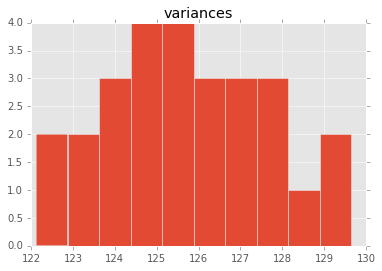

In [17]:
decorrVars = np.array([dc[0] for dc in decorrStats])
print len(decorrVars), decorrVars
print (decorrVars.max()-decorrVars.min())/decorrVars.mean(), decorrVars.std()/decorrVars.mean()
import pandas as pd
pd.DataFrame({'variances': decorrVars}).hist(bins=10)

So it looks like the variance (note this is the *mean variance of the entire image*) could be off by up to nearly 6% if we use the wrong combination of kernel and variances in the decorrelation.

This would suggest that we *do* need to compute these parameters on a spatially-varying scale and then interpolate.

This should be possible, even if the spatially-varying kernel option only uses linear basis functions, if we use a "pixel" or delta-function basis.